# Apprendimento Strutturale
L' obiettivo di questa parte prendere automaticamente la struttura di una Rete Bayesiana a partire dallo stesso Dataset visto nei capitoli precedenti (cercando di preservare quante più feature possibili). Una Rete Bayesiana è un modello probabilistico che rappresenta le relazioni di dipendenza tra variabili attraverso un grafo aciclico diretto (DAG).

Attraverso l’apprendimento strutturale, vogliamo scoprire quali fattori influenzano maggiormente la dinamica degli incidenti stradali. 

Questo ci permetterà di: <br> 

- Identificare le relazioni causali o di dipendenza tra le variabili (es. condizioni meteo e fondo stradale).
- Comprendere quali fattori aumentano il rischio di incidenti gravi.
- Supportare le analisi predittive per la prevenzione degli incidenti.

## Cos'è una Rete Bayesiana?
Una Rete Bayesiana è una rappresentazione grafica delle dipendenze probabilistiche tra variabili casuali. 

È composta da: <br>

- **Nodi**, che rappresentano le variabili del problema (es. meteo, tipo di strada, gravità dell’incidente).
- **Archi diretti**, che indicano una relazione di dipendenza tra due variabili (es. "il meteo influenza il fondo stradale").
- **Matematicamente**, una Rete Bayesiana modella una distribuzione congiunta di probabilità secondo la formula:
  $$P(X_1, X_2, \ldots, X_n) = \prod_{i=1}^{n} P(X_i \mid \text{genitori}(X_i))$$
Dove ogni variabile $𝑋_𝑖$ dipende solo dalle sue **variabili genitrici**, semplificando il calcolo delle probabilità.

### Approccio:
Il processo prevede due fasi:

- Definizione di una funzione di punteggio per valutare la qualità di una data struttura. Nel nostro caso, abbiamo usato il Bayesian Information Criterion (BIC), che bilancia l’adattamento ai dati e la complessità del modello.
- Ricerca della struttura ottimale, utilizzando l'algoritmo di Hill Climbing, che esplora diverse strutture di rete per trovare quella che massimizza il punteggio scelto.
 Il **BIC** valuta la qualità di un modello bilanciando accuratezza e complessità:

$$BIC = \log P(D | M) - \frac{k}{2} \log N$$

- Premia modelli **più semplici** per evitare overfitting.  
- Il **BIC più alto** indica il miglior modello.


L'algoritmo di Hill Climbing è una tecnica di ottimizzazione per apprendere la struttura della rete bayesiana.
**Fasi**:<br>

1. **Inizializza** con una rete casuale.
2. **Modifica** la struttura (aggiungi/rimuovi archi).
3. **Valuta** con un punteggio (es. BIC).
4. **Aggiorna** se migliora.
5. **Ferma** quando il punteggio non migliora più.

### Preprocessing del Dataset:

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder

# ----------------------------------------------------------
# 1. CARICAMENTO DEL DATASET
# ----------------------------------------------------------
this_path = os.getcwd()
dataSet_path = os.path.join(this_path, 'Dati', "DataSet_Incidenti_Puglia.csv")
target_path = os.path.join(this_path, 'Dati', "BN.csv")

# Carica il dataset originale
df = pd.read_csv(dataSet_path, low_memory=False)

# Seleziona solo le colonne rilevanti per l'analisi
selected_columns = [
    "METEO", "FONDOST", "LUCE",    
    "LOCINC", "ORA_APP", "TIPOST", "INTNIN",  
    "NATINC", "DUERUOTE", "INCBICI", "INCPED",  
    "MORTI", "FERITI",
    "SEGNAL", "PAVIM"
]

df = df[selected_columns]

# ----------------------------------------------------------
# 2. GESTIONE VALORI MANCANTI
# ----------------------------------------------------------

# Step 1: Converti la stringa "non ammesso" in NaN per la colonna SEGNAL
df['SEGNAL'] = df['SEGNAL'].replace({'non ammesso': np.nan})

# Step 2: Calcola la moda globale della colonna SEGNAL per sostituire i NaN
global_segnal_mode = df['SEGNAL'].mode()[0]

# Step 3: Imputazione condizionata a TIPOST, se possibile
df['SEGNAL'] = df.groupby('TIPOST')['SEGNAL'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else global_segnal_mode
)

# Step 4: Se rimangono NaN dopo il raggruppamento, sostituiscili con la moda globale
df['SEGNAL'] = df['SEGNAL'].fillna(global_segnal_mode)

# Step 5: Per PAVIM, riempiamo i valori mancanti con la moda della colonna
df['PAVIM'] = df['PAVIM'].fillna(df['PAVIM'].mode()[0])

# ----------------------------------------------------------
# 3. NORMALIZZAZIONE DELL'ORA IN FASCE ORARIE
# ----------------------------------------------------------

# L'ora è registrata da 1 a 25, quindi la riportiamo nel range 0-24
df["ORA_APP"] = df["ORA_APP"].apply(lambda x: x - 1 if x <= 24 else 0)

# Creazione della variabile FASCIA_ORARIA
df['FASCIA_ORARIA'] = pd.cut(df['ORA_APP'],
                             bins=[0, 6, 12, 18, 24],
                             labels=['Notte', 'Mattina', 'Pomeriggio', 'Sera'],
                             include_lowest=True)

df = df.drop(columns=['ORA_APP'])  # Rimuoviamo la colonna originale dell'ora

# ----------------------------------------------------------
# 4. CREAZIONE DELLA VARIABILE TARGET (GRAVITA)
# ----------------------------------------------------------
# Poiché il dataset non ha incidenti senza feriti, possiamo rimuovere il caso GRAVITA=0.
# Manteniamo solo due categorie:
# 2 = incidente mortale
# 1 = incidente con feriti

df['GRAVITA'] = np.where(df['MORTI'] > 0, 2, 1)  # Se MORTI > 0 -> 2 (mortale), altrimenti 1 (feriti)
df = df.drop(columns=['MORTI', 'FERITI'])  # Rimuoviamo le colonne originali

# ----------------------------------------------------------
# 5. SEMPLIFICAZIONE DELLE CATEGORIE RARE
# ----------------------------------------------------------

# Raggruppiamo le categorie meno frequenti in una nuova etichetta "Altro"
df['INTNIN'] = np.where(df['INTNIN'].isin([1,2,3,4,7,8]), df['INTNIN'], 13)  # 13 = Altro
df['NATINC'] = np.where(df['NATINC'].isin([1,4,5,10]), df['NATINC'], 13)     # 13 = Altro

# ----------------------------------------------------------
# 6. CODIFICA VARIABILI CATEGORICHE
# ----------------------------------------------------------
# Convertiamo le variabili categoriche in numeri per l'analisi

encoder = LabelEncoder()
categorical_cols = ['METEO', 'FONDOST', 'LUCE', 'LOCINC', 
                    'TIPOST', 'INTNIN', 'NATINC', 'SEGNAL', 'PAVIM']

for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# ----------------------------------------------------------
# 7. CONTROLLO FINALE
# ----------------------------------------------------------
# Stampiamo un riepilogo dei dati elaborati per verificare il corretto pre-processing

print("\n*** DISTRIBUZIONE VARIABILI ***")
print("Gravità incidenti:")
print(df['GRAVITA'].value_counts(normalize=True))  # Frequenze relative della variabile target

print("\nTipologia strade:")
print(df['TIPOST'].value_counts(normalize=True))  # Contiamo il numero di occorrenze per tipo di strada

print("\nDataset finale:")
print(df.head())  # Mostriamo le prime righe del dataset elaborato

# ----------------------------------------------------------
# 8. SALVATAGGIO
# ----------------------------------------------------------
# Salviamo il dataset pre-elaborato in un nuovo file CSV
df.to_csv(target_path, index=False)

print("\nPreprocessing completato!")



*** DISTRIBUZIONE VARIABILI ***
Gravità incidenti:
GRAVITA
1    0.981888
2    0.018112
Name: proportion, dtype: float64

Tipologia strade:
TIPOST
1    0.599561
0    0.235515
2    0.157692
3    0.007232
Name: proportion, dtype: float64

Dataset finale:
   METEO  FONDOST  LUCE  LOCINC  TIPOST  INTNIN  NATINC  DUERUOTE  INCBICI  \
0      0        0     3       5       1       5       3         0        0   
1      6        0     3       5       2       4       4         0        0   
2      6        0     3       5       1       4       4         0        0   
3      0        1     3       5       0       5       4         0        0   
4      0        0     3       5       0       4       4         0        0   

   INCPED  SEGNAL  PAVIM FASCIA_ORARIA  GRAVITA  
0       0       3      0       Mattina        1  
1       0       2      0    Pomeriggio        1  
2       0       3      0    Pomeriggio        1  
3       0       3      0    Pomeriggio        1  
4       0       3      0    

### 1° Prova di costruzione della Rete

  0%|          | 0/1000000 [00:00<?, ?it/s]

*** STRUTTURA AUTOMATICA ***
Archi suggeriti: [('METEO', 'FONDOST'), ('LUCE', 'FASCIA_ORARIA'), ('LUCE', 'INCBICI'), ('LOCINC', 'TIPOST'), ('LOCINC', 'DUERUOTE'), ('LOCINC', 'GRAVITA'), ('LOCINC', 'SEGNAL'), ('INTNIN', 'SEGNAL'), ('INTNIN', 'LOCINC'), ('INTNIN', 'TIPOST'), ('NATINC', 'INCPED'), ('NATINC', 'LOCINC'), ('NATINC', 'INTNIN'), ('NATINC', 'DUERUOTE'), ('DUERUOTE', 'INCBICI'), ('DUERUOTE', 'METEO'), ('DUERUOTE', 'FONDOST'), ('SEGNAL', 'PAVIM'), ('FASCIA_ORARIA', 'NATINC')]


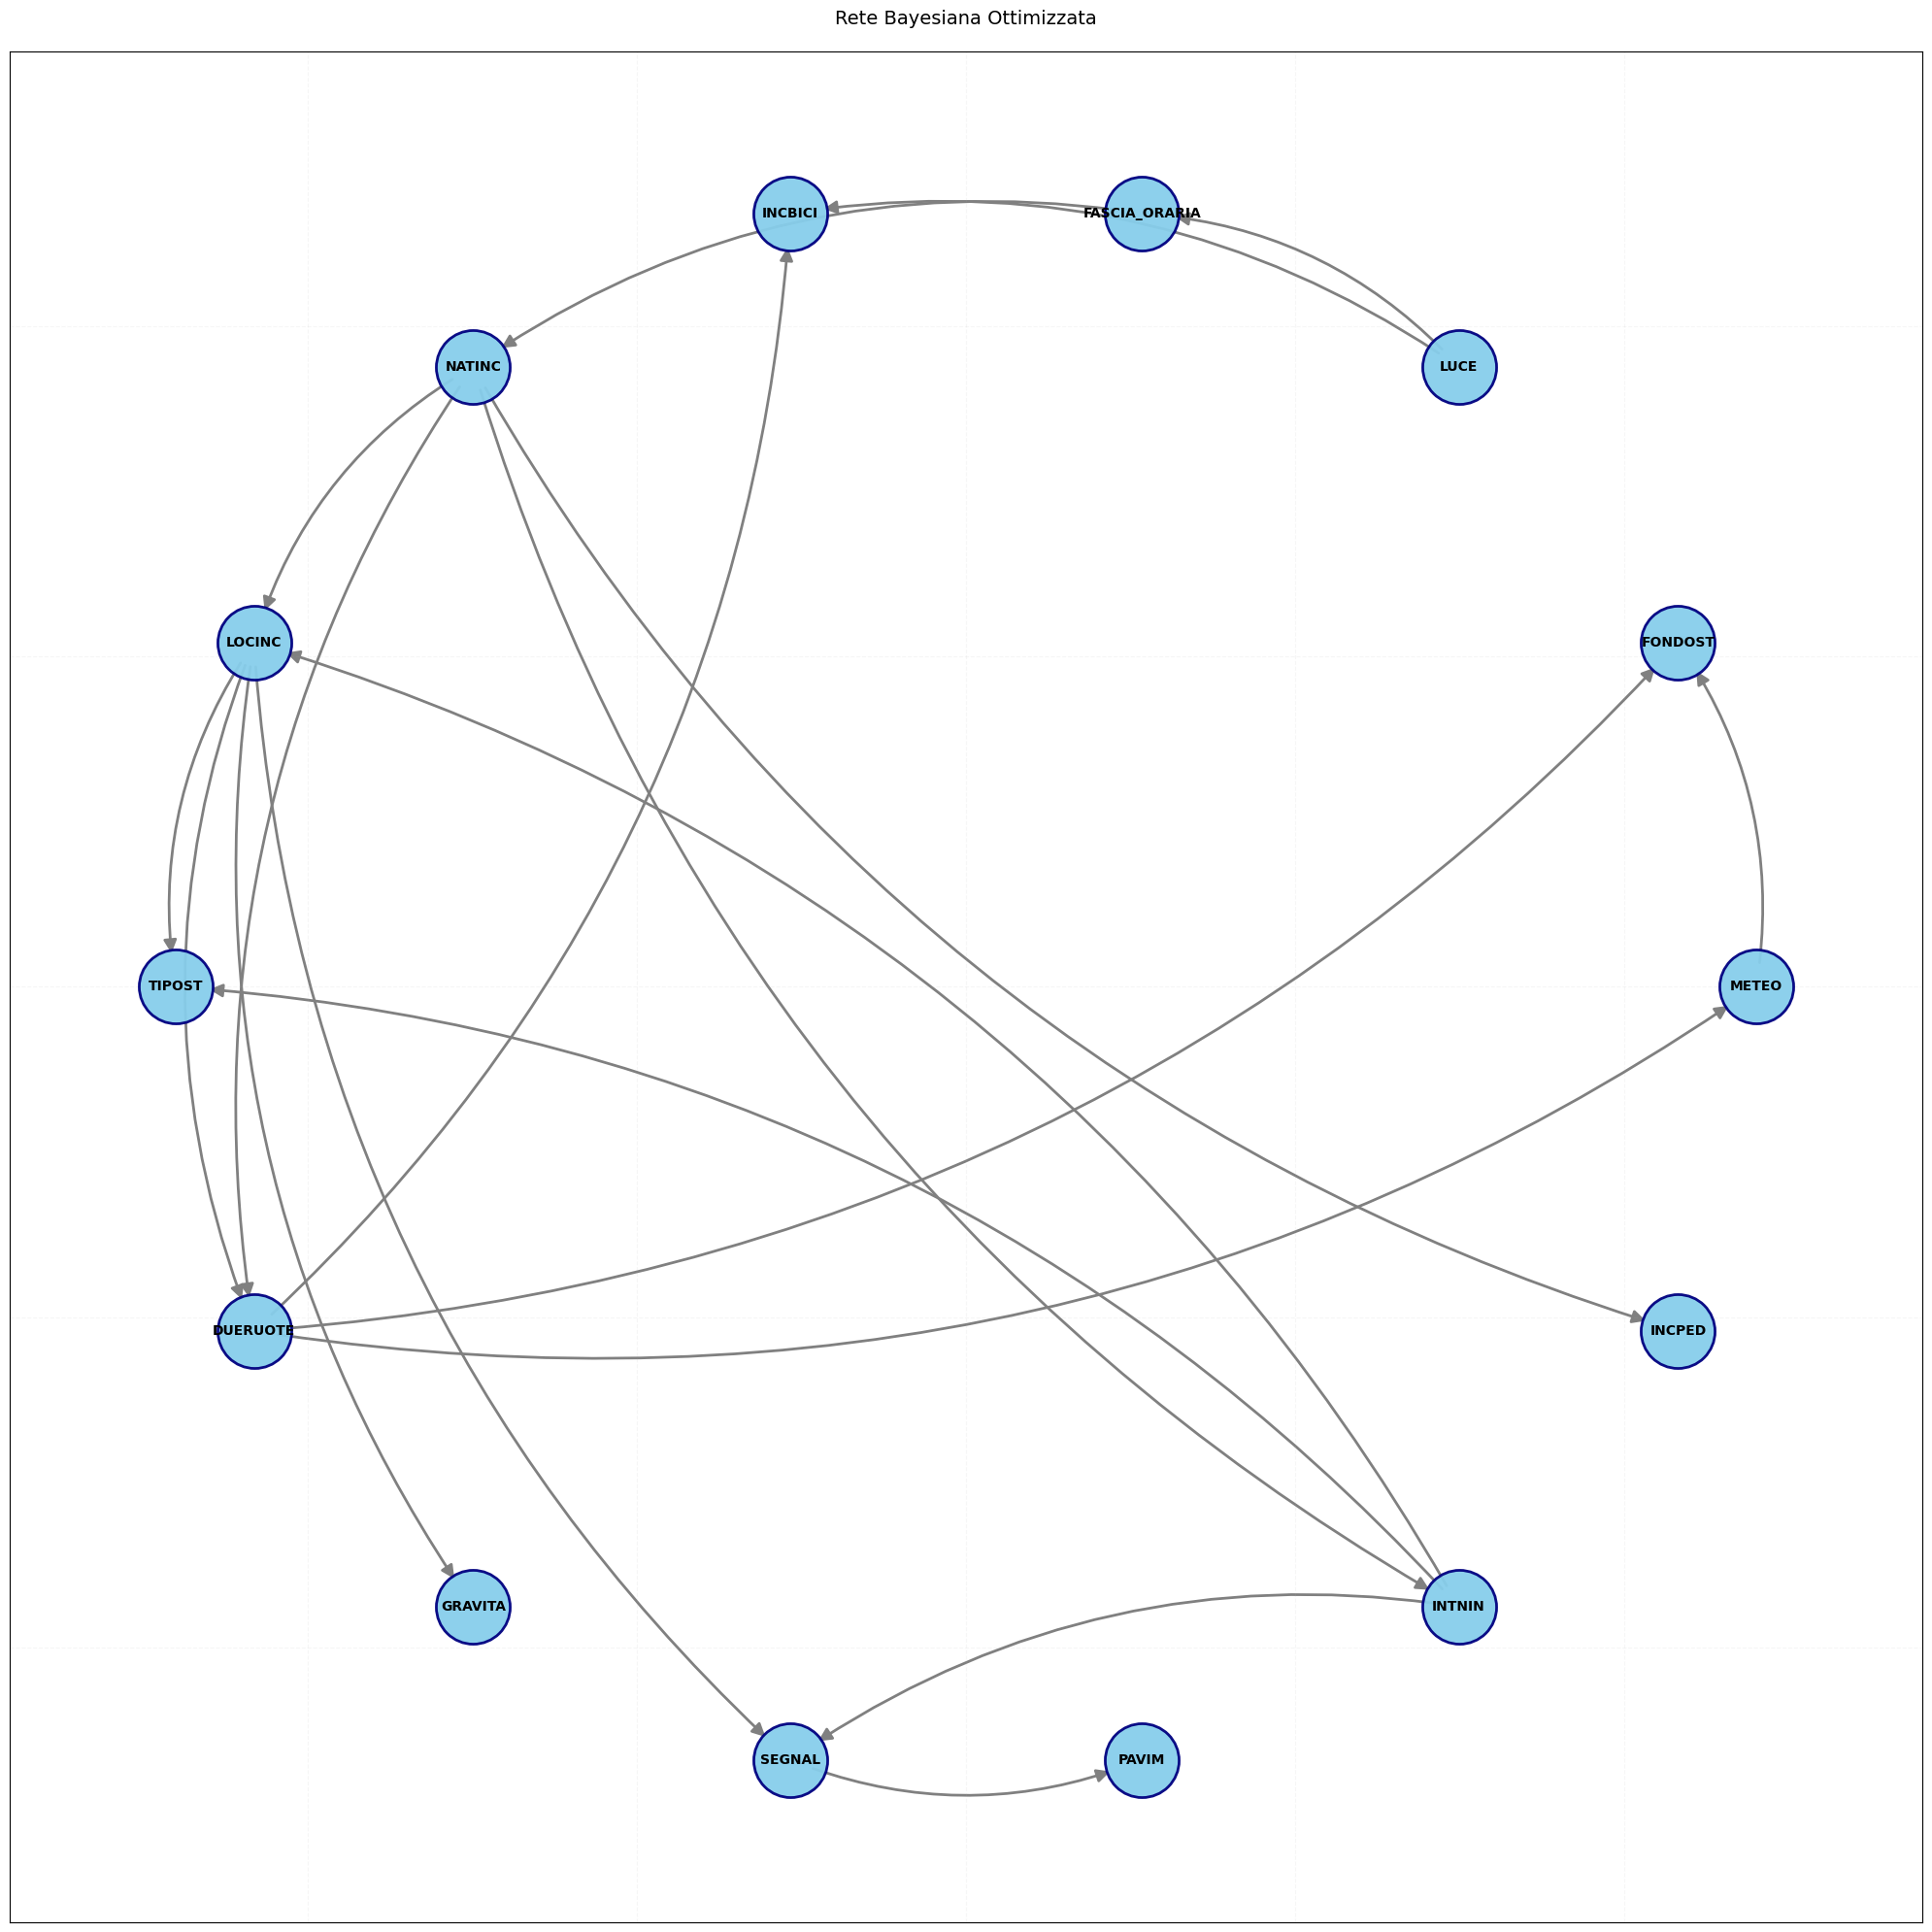

Grafo della rete aciclico:  True


In [5]:
from pgmpy.estimators import HillClimbSearch, BicScore  # Algoritmo di apprendimento strutturale
from pgmpy.models import BayesianNetwork  # Creazione della rete bayesiana
from networkx.algorithms.dag import is_directed_acyclic_graph  # Verifica se la rete è un DAG
import matplotlib.pyplot as plt  # Per la visualizzazione grafica
import networkx as nx  # Per la gestione della rete
import pandas as pd  # Per il caricamento del dataset
import os  # Per la gestione dei percorsi file

# ----------------------------------------------------------
# 1️ CARICAMENTO DEL DATASET
# ----------------------------------------------------------

# Ottiene il percorso attuale della cartella di lavoro
this_path = os.getcwd()

# Definisce il percorso del dataset
# target_path = os.path.join(this_path, 'Dati', "NaiveBalanced.csv")  # Dataset bilanciato (opzionale)
target_path = os.path.join(this_path, 'Dati', "BN.csv")  # Dataset principale

# Caricamento del dataset con Pandas
df = pd.read_csv(target_path, low_memory=False)

# ----------------------------------------------------------
# 2️ APPRENDIMENTO DELLA STRUTTURA DELLA RETE BAYESIANA
# ----------------------------------------------------------

# Creazione dell'oggetto Hill Climbing per stimare la struttura della rete
hc = HillClimbSearch(df)

# Stima della migliore struttura della rete utilizzando il punteggio BIC
best_model = hc.estimate(scoring_method=BicScore(df))

# Stampa gli archi appresi dalla rete
print("*** STRUTTURA AUTOMATICA ***")
print("Archi suggeriti:", best_model.edges())

# ----------------------------------------------------------
# 3️ CREAZIONE DEL MODELLO DI RETE BAYESIANA
# ----------------------------------------------------------

# Creazione della rete bayesiana utilizzando gli archi trovati con Hill Climbing
rete = BayesianNetwork(best_model.edges())

# ----------------------------------------------------------
# 4️ VISUALIZZAZIONE DELLA RETE BAYESIANA
# ----------------------------------------------------------

def plot_bn(model):
    """
    Funzione per visualizzare la Rete Bayesiana con NetworkX e Matplotlib.
    
    Parametri:
    - model: Oggetto BayesianNetwork contenente la struttura della rete.
    """
    
    # Imposta le dimensioni della figura
    plt.figure(figsize=(20, 20))

    # Creazione del grafo diretto
    G = nx.DiGraph()  
    G.add_edges_from(model.edges())  # Aggiunge gli archi al grafo

    # Layout circolare per la disposizione dei nodi
    pos = nx.circular_layout(G)

    # Espande leggermente le posizioni per evitare sovrapposizioni
    pos = {node: (x*1.2, y*1.2) for node, (x, y) in pos.items()}  

    # Configurazione dei parametri di visualizzazione
    node_size = 3000  # Dimensione dei nodi
    font_size = 10  # Dimensione del testo
    edge_width = 2  # Spessore delle linee degli archi
    arrow_size = 20  # Dimensione delle frecce degli archi

    # Disegna gli archi con stile curvo per maggiore leggibilità
    nx.draw_networkx_edges(
        G, pos,
        arrows=True,
        arrowstyle="-|>",
        arrowsize=arrow_size,
        edge_color="grey",
        width=edge_width,
        connectionstyle="arc3,rad=0.2",  # Leggera curvatura degli archi
        min_source_margin=18,
        min_target_margin=25
    )

    # Disegna i nodi con colore e bordo personalizzati
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_size,
        node_color="skyblue",
        edgecolors="navy",
        linewidths=2,
        alpha=0.95
    )

    # Disegna le etichette dei nodi
    nx.draw_networkx_labels(
        G, pos,
        font_size=font_size,
        font_weight="bold",
        font_family="sans-serif",
        verticalalignment="center",
        horizontalalignment="center"
    )

    # Aggiunge una griglia di sfondo leggera per maggiore chiarezza
    plt.grid(visible=True, which='both', axis='both', linestyle='--', alpha=0.1)
    
    # Imposta il titolo della figura
    plt.title("Rete Bayesiana Ottimizzata", fontsize=14, pad=20)

    # Migliora il layout per evitare sovrapposizioni
    plt.tight_layout()
    
    # Mostra la rete
    plt.show()

# Chiamata alla funzione di visualizzazione
plot_bn(rete)

# ----------------------------------------------------------
# 5️ VERIFICA DELLA CONSISTENZA DEL GRAFO
# ----------------------------------------------------------

# Controlla se la rete è un grafo aciclico diretto (DAG)
print("Grafo della rete aciclico: ", is_directed_acyclic_graph(rete))


Dal grafico, cosi come dagli archi suggeriti sono evidenti alcune regole
### Alcune Relazioni Anomale o potenzialmente Anomale:<br>

- **(DUERUOTE → METEO) e (DUERUOTE → FONDOST)**
La presenza di veicoli a due ruote non dovrebbe influenzare direttamente il meteo o il fondo stradale.
Questo potrebbe essere un effetto spurio, forse perché alcuni tipi di fondo stradale sono più pericolosi per le due ruote.
- **(LUCE → INCBICI)**
L’illuminazione della strada influenza direttamente la probabilità di incidenti con biciclette?
Potrebbe essere una correlazione indiretta con la fascia oraria (più biciclette di giorno).
- **(FASCIA_ORARIA → NATINC)**
La fascia oraria determina direttamente il tipo di incidente?
Alcuni tipi di incidenti (es. investimento pedoni) sono più frequenti in certe fasce orarie, ma il legame diretto potrebbe non essere così forte.
- **(INCPED → LUCE)**
E' evidente che abbia poco senso logico.

### Testiamo l'indipendeza di alcunre relazioni sospette:
Utilizziamo il **test-chiquadrato** e il **coefficiente Cramer's V**, che misura la forza dell'associazione tra variabili.

In [6]:
# Importazione delle librerie necessarie
from scipy.stats import chi2_contingency  # Per il test del chi-quadrato
import pandas as pd  # Per la gestione del dataset
import numpy as np  # Per i calcoli matematici

# ----------------------------------------------------------
# 1 DEFINIZIONE DELLA FUNZIONE DI TEST DI INDIPENDENZA
# ----------------------------------------------------------

def test_indipendenza(var1, var2, df):
    """
    Funzione per testare l'indipendenza tra due variabili categoriche.
    Utilizza il test del chi-quadrato e calcola Cramér's V per valutare la forza dell'associazione.

    Parametri:
    - var1: Nome della prima variabile (colonna del dataframe)
    - var2: Nome della seconda variabile (colonna del dataframe)
    - df: DataFrame contenente i dati

    Output:
    - P-value del test del chi-quadrato
    - Cramér's V per misurare la forza della relazione
    """

    # Creazione della tabella di contingenza (frequenze tra le due variabili)
    contingency_table = pd.crosstab(df[var1], df[var2])

    # Esegui il test del chi-quadrato
    chi2, p_value, _, expected = chi2_contingency(contingency_table)

    # Calcolo di Cramér's V
    n = np.sum(contingency_table.values)  # Numero totale di osservazioni
    min_dim = min(contingency_table.shape) - 1  # Minimo tra (righe-1, colonne-1)
    
    # Formula di Cramér's V: sqrt(χ² / (n * min_dim))
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0

    # Stampa i risultati
    print(f"Test di indipendenza tra {var1} → {var2}")
    print(f"  - P-value: {p_value:.5f}")  # Probabilità di indipendenza
    print(f"  - Cramér's V: {cramers_v:.3f} (0 = nessuna relazione, 1 = relazione forte)")
    print("--------------------------------------------------")

# ----------------------------------------------------------
# 2️ ESECUZIONE DEL TEST SU RELAZIONI SOSPETTE NEL MODELLO
# ----------------------------------------------------------

# Esegue il test per le relazioni trovate dalla rete bayesiana per verificarne la significatività

test_indipendenza('DUERUOTE', 'METEO', df)  # Veicoli a due ruote influenzano il meteo?
test_indipendenza('DUERUOTE', 'FONDOST', df)  # Veicoli a due ruote influenzano il fondo stradale?
test_indipendenza('DUERUOTE', 'INCBICI', df)  # Incidenti con due ruote coinvolgono più spesso biciclette?
test_indipendenza('LOCINC', 'DUERUOTE', df)  # La posizione dell'incidente influisce sulla presenza di due ruote?
test_indipendenza('LUCE', 'INCBICI', df)  # L'illuminazione influisce sulla probabilità di incidenti in bici?
test_indipendenza('FASCIA_ORARIA', 'DUERUOTE', df)  # Gli incidenti con due ruote variano in base alla fascia oraria?
test_indipendenza('NATINC', 'FASCIA_ORARIA', df)  # Il tipo di incidente cambia a seconda dell'orario?
test_indipendenza('DUERUOTE', 'FASCIA_ORARIA', df)  # Gli incidenti con due ruote sono più frequenti in alcune fasce?
test_indipendenza('INCPED', 'LUCE', df)  # La visibilità influisce sugli incidenti con pedoni?
test_indipendenza('SEGNAL', 'PAVIM', df)  # La segnaletica è legata al tipo di pavimentazione?


Test di indipendenza tra DUERUOTE → METEO
  - P-value: 0.00000
  - Cramér's V: 0.125 (0 = nessuna relazione, 1 = relazione forte)
--------------------------------------------------
Test di indipendenza tra DUERUOTE → FONDOST
  - P-value: 0.00000
  - Cramér's V: 0.138 (0 = nessuna relazione, 1 = relazione forte)
--------------------------------------------------
Test di indipendenza tra DUERUOTE → INCBICI
  - P-value: 0.00000
  - Cramér's V: 0.351 (0 = nessuna relazione, 1 = relazione forte)
--------------------------------------------------
Test di indipendenza tra LOCINC → DUERUOTE
  - P-value: 0.00000
  - Cramér's V: 0.212 (0 = nessuna relazione, 1 = relazione forte)
--------------------------------------------------
Test di indipendenza tra LUCE → INCBICI
  - P-value: 0.00000
  - Cramér's V: 0.030 (0 = nessuna relazione, 1 = relazione forte)
--------------------------------------------------
Test di indipendenza tra FASCIA_ORARIA → DUERUOTE
  - P-value: 0.00000
  - Cramér's V: 0.089

# Validazione della Rete Bayesiana tramite Test di Indipendenza

Abbiamo verificato la robustezza delle connessioni apprese nella rete bayesiana tramite il **test del chi-quadrato di indipendenza**.  
Le relazioni sono state valutate in base al **P-value** (significatività statistica) e al **Cramér's V** (forza dell'associazione).

## 1 Connessioni Forti e Significative (Manteniamo)
- **DUERUOTE → INCBICI** (Cramér's V = 0.351)  
- **LOCINC → DUERUOTE** (Cramér's V = 0.212)  
**Queste relazioni sono coerenti con il fenomeno degli incidenti stradali e vengono mantenute nella rete.**

## 2️ Connessioni Moderate (Verificare)
- **DUERUOTE → METEO** (Cramér's V = 0.125)  
- **DUERUOTE → FONDOST** (Cramér's V = 0.138)  
**Dal punto di vista analitico potrebbero essere mantenute, ma è ovvio che non sia logico.** 

## 3️ Connessioni Deboli (Da Rimuovere)
- **LUCE → INCBICI** (Cramér's V = 0.030)  
- **FASCIA_ORARIA → DUERUOTE** (Cramér's V = 0.089)  
- **NATINC → FASCIA_ORARIA** (Cramér's V = 0.084)  
- **DUERUOTE → FASCIA_ORARIA** (Cramér's V = 0.089)  
- **INCPED → LUCE** (Cramér's V = 0.020)  
- **SEGNAL → PAVIM** (Cramér's V = 0.062)  

### Proviamo a ricostruire la rete con quello che abbiamo appreso:

  0%|          | 0/1000000 [00:00<?, ?it/s]

*** STRUTTURA OTTIMIZZATA ***
Archi selezionati: [('METEO', 'FONDOST'), ('FONDOST', 'PAVIM'), ('LUCE', 'FASCIA_ORARIA'), ('FASCIA_ORARIA', 'NATINC'), ('LOCINC', 'TIPOST'), ('LOCINC', 'DUERUOTE'), ('LOCINC', 'GRAVITA'), ('LOCINC', 'SEGNAL'), ('DUERUOTE', 'INCBICI'), ('INTNIN', 'SEGNAL'), ('INTNIN', 'LOCINC'), ('INTNIN', 'TIPOST'), ('INTNIN', 'METEO'), ('NATINC', 'INCPED'), ('NATINC', 'LOCINC'), ('NATINC', 'INTNIN'), ('NATINC', 'DUERUOTE'), ('NATINC', 'INCBICI')]


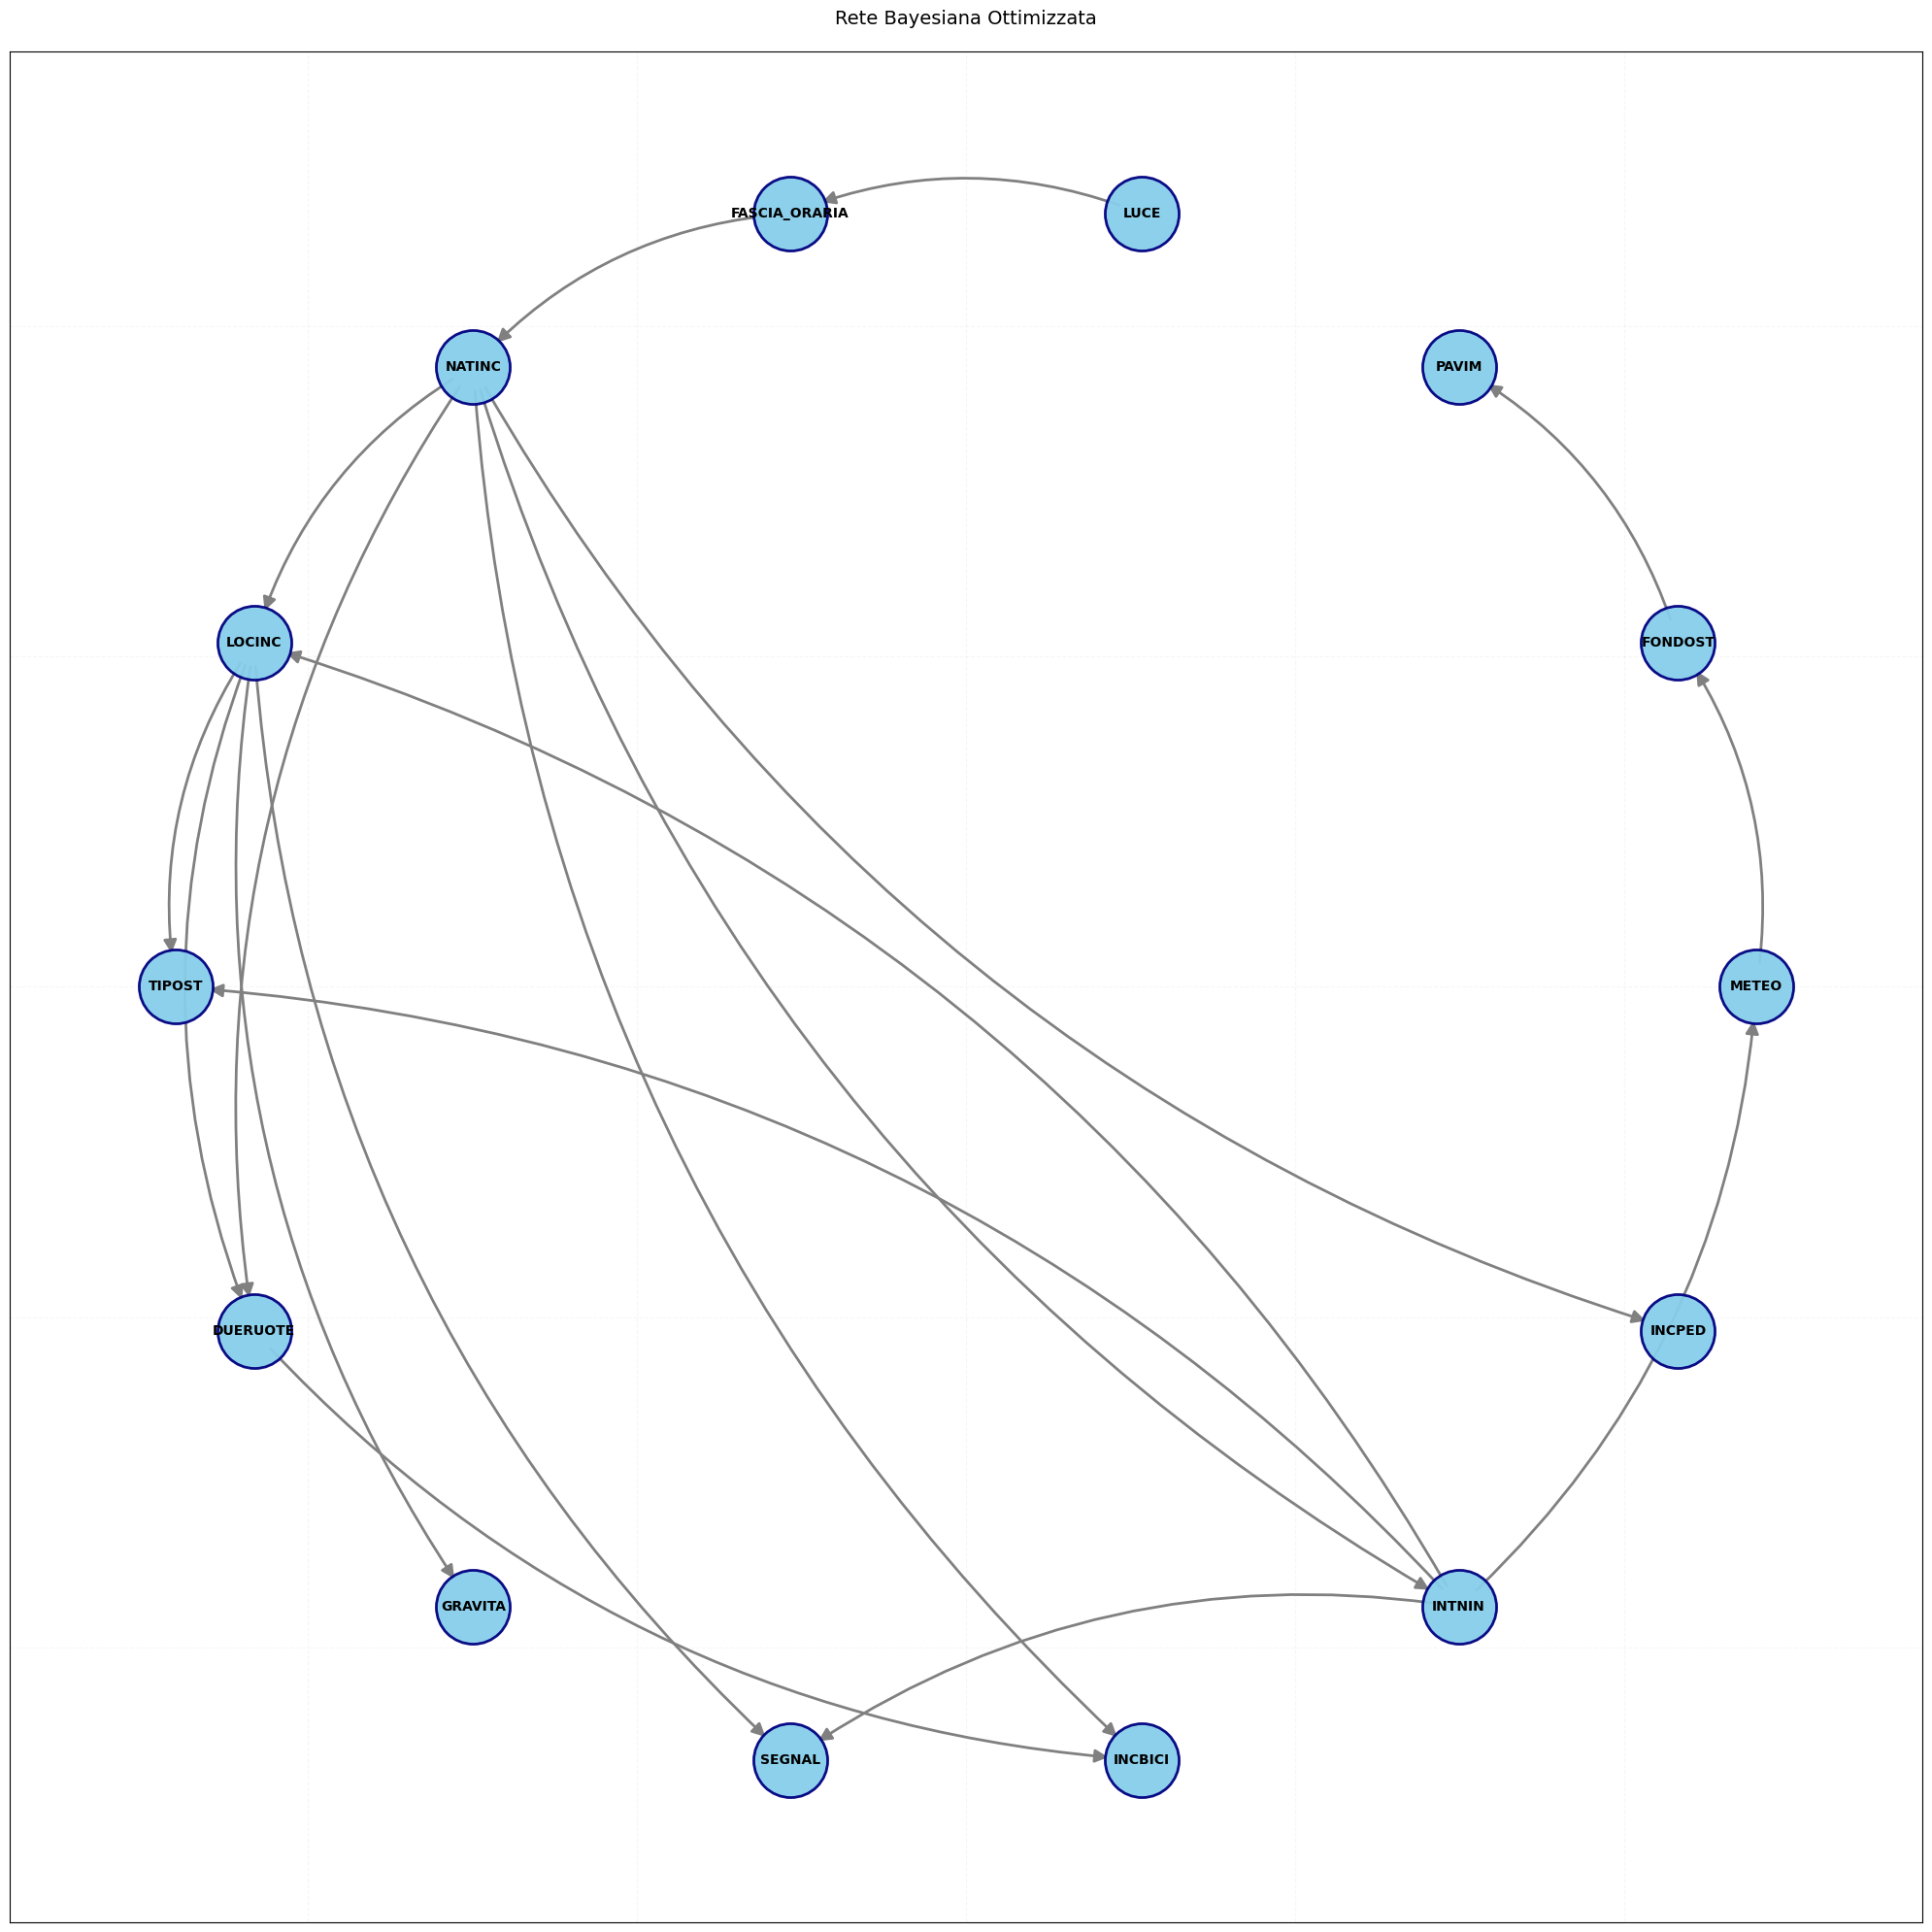

In [14]:
# Caricamento dati
this_path = os.getcwd()
target_path = os.path.join(this_path, 'Dati', "BN.csv")
df = pd.read_csv(target_path, low_memory=False)

# Definizione delle relazioni da escludere
black_list = [
    ('DUERUOTE', 'FONDOST'),
    ('DUERUOTE', 'METEO'),
    ('LUCE', 'INCBICI'),
    ('FASCIA_ORARIA', 'DUERUOTE'),
    ('NATINC', 'FASCIA_ORARIA'),
    ('DUERUOTE', 'FASCIA_ORARIA'),
    ('INCPED', 'LUCE'),
    ('SEGNAL', 'PAVIM'),
    ('FONDOST', 'LUCE'),
    ('NATINC', 'METEO')
]

# Apprendimento struttura con vincoli
hc = HillClimbSearch(df)
best_model = hc.estimate(
    scoring_method=BicScore(df),
    black_list=black_list,
)
# max_indegree=4   Limita la complessità

# Creazione e validazione rete
rete = BayesianNetwork(best_model.edges())
print("*** STRUTTURA OTTIMIZZATA ***")
print("Archi selezionati:", rete.edges())

plot_bn(rete)

L’apprendimento strutturale della rete bayesiana, applicato al dataset sugli incidenti stradali in Puglia, ha prodotto risultati significativi ma ha anche evidenziato criticità e opportunità di miglioramento.

## **Risultati Chiave**  
**Struttura Appresa e Ottimizzazione**<br>

   - L’algoritmo **Hill Climbing** con punteggio **BIC** ha individuato relazioni iniziali tra variabili (es.: `DUERUOTE → METEO`), alcune delle quali illogiche.  
   - Dopo la validazione tramite **test del chi-quadrato** e **Cramer’s V**, archi spurii (es.: `INCPED → LUCE`, Cramer’s V = 0.020) sono stati rimossi, ottenendo una rete più coerente.  
   - La struttura ottimizzata include relazioni rilevanti come:  
     - `LOCINC → GRAVITA`: la localizzazione geografica influisce sulla gravità degli incidenti.  
     - `FASCIA_ORARIA → NATING`: certi tipi di incidenti sono associati a specifiche fasce orarie.  

**Limiti Emersi**<br>

   - **Squilibrio del target**: Il 98% degli incidenti è classificato come "non mortale" (`GRAVITA=1`), riducendo la capacità predittiva per eventi gravi.  
   - **Categorizzazione delle variabili**: L’aggregazione di categorie rare in "Altro" (es.: `INTNIN=13`) potrebbe aver semplificato eccessivamente dinamiche complesse.  
   - **Correlazioni spurie**: Alcune dipendenze identificate (es.: `DUERUOTE → FONDOST`) sono statisticamente significative ma logicamente dubbiose, suggerendo la necessità di validazione esterna.

---

## **Sviluppi Futuri**  
**Miglioramento della Qualità del Dataset**<br>

   - **Bilanciamento del target**: Applicare tecniche di **oversampling** (es.: SMOTE) o raccogliere dati aggiuntivi su incidenti mortali per ridurre lo squilibrio.  
   - **Affinamento delle categorie**: Evitare l’aggregazione automatica in "Altro" per variabili come `INTNIN`, preservando dettagli critici attraverso collaborazioni con enti locali.  

**Validazione Esperta delle Relazioni**<br> 

   - Coinvolgere **ingegneri del traffico** o **urbanisti** per:  
     - Confermare la plausibilità di archi come `FASCIA_ORARIA → NATING`.

**Rafforzamento del Modello**<br>

   - **Modelli ibridi**: Combinare reti bayesiane con algoritmi di machine learning (es.: Random Forest) per migliorare la capacità predittiva.
   - **Dati storici**: Si potrebbero integrare più dati storici per rafforzare alcune relazioni.

--- 